In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import os
import sys
import numpy as np
import collections
import scipy.io
import time
import cPickle as pickle

# CNN bits
import theano
import theano.tensor as T
import lasagne
from lasagne import layers

# for evaluation
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
sys.path.append('../')
from engaged.features import evaluation, cnn_utils
import urban8k_helpers as helpers

from sklearn import metrics
from sklearn.metrics import roc_curve, auc


# https://groups.google.com/forum/#!topic/lasagne-users/t_rMTLAtpZo
theano.config.profile = True
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn import metrics

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled)


In [2]:
base_path = '/media/michael/Seagate/urban8k/'

minibatch_size = 40
do_median_normalise = True
slice_width = 128
all_accuracies = collections.defaultdict(list)
all_auc = collections.defaultdict(list)

for runname in ['train_data', 'train_and_val_data']:
    
    for split in range(1, 11):

        all_preds = []
        all_gt = []

        # loading data
        loadpath = base_path + 'splits_128/split' + str(split) + '.pkl'
        dataset, num_classes = helpers.load_data(loadpath)

        test_X, test_y = helpers.form_slices_validation_set(
            dataset, slice_width, do_median_normalise, key='test_')

        # loading model
        foldername = 'split_%d_' + runname
        modelloadpath = ('../results/full_split_run_0003/' + \
                         foldername + '/final_model.pkl') % split
        if not os.path.exists(modelloadpath):
            print "Not found ", modelloadpath
            continue
        network, predict_fn, results = pickle.load(open(modelloadpath))

        # doing prediction
        for inputs, targets in helpers.iterate_minibatches(
                test_X, test_y, int(minibatch_size), slice_width):
            preds = predict_fn(inputs)
            all_preds.append(preds)
            all_gt.append(targets)

        all_preds = np.vstack(all_preds)
        all_gt = np.hstack(all_gt)

        # recording the final metrics
        acc = metrics.accuracy_score(np.argmax(all_preds, axis=1), all_gt)
        all_accuracies[runname].append(acc)

        auc = cnn_utils.multiclass_auc(all_gt, all_preds)
        all_auc[runname].append(auc)

Loading data
There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]
train_X 6971 train_y 6971 val_y 888 val_X 888 test_y 873 test_X 873 validation set is of size  (873, 1, 128, 128) (873,)
Loading data
There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]
train_X 6919 train_y 6919 val_y 925 val_X 925 test_y 888 test_X 888 validation set is of size  (888, 1, 128, 128) (888,)
Loading data
There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]
train_X 6817 train_y 6817 val_y 990 val_X 990 test_y 925 test_X 925 validation set is of size  (925, 1, 128, 128) (925,)
Loading data
There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]
train_X 6806 train_y 6806 val_y 936 val_X 936 test_y 990 test_X 990 validation set is of size  (990, 1, 128, 128) (990,)
Loading data
There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]
train_X 6973 train_y 6973 val_y 823 val_X 823 test_y 936 test_X 936 validation set is of size  (936, 1, 128, 128) (936,)
Loading data
There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]
train_X 7071 train_y 7071 val_y 838 val_X 838 test_y 

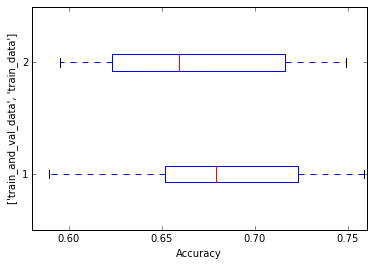

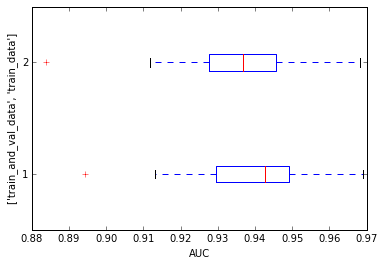

In [3]:
plt.boxplot(all_accuracies.values(), 0, 'r+', 0)
plt.xlabel('Accuracy')
plt.ylabel(all_accuracies.keys())

plt.figure()
plt.boxplot(all_auc.values(), 0, 'r+', 0)
plt.xlabel('AUC')
plt.ylabel(all_auc.keys())

In [5]:
# print the timings...


0


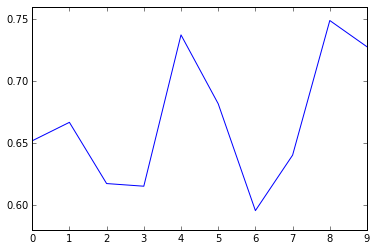

In [4]:
accs = all_accuracies['train_data']
print np.argmin(np.abs(accs - np.median(accs)))
plt.plot(accs)

In [31]:
import pandas as pd
base_path = '/media/michael/Seagate/urban8k/'
meta_path = base_path + 'UrbanSound8K/metadata/UrbanSound8K.csv'

unique_labels = [''] * 10

# data = 
data = pd.read_csv(meta_path)
for row in data.iterrows():
    unique_labels[row[1]['classID']] = row[1]['class']
# print data
print unique_labels 

['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [32]:
cm = metrics.confusion_matrix(np.argmax(all_preds, axis=1), all_gt)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(unique_labels))
    plt.xticks(tick_marks, unique_labels, rotation=75)

    plt.yticks(tick_marks, unique_labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 12}

plt.rc('font', **font)
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cm)

ValueError: axis(=1) out of bounds